In [119]:
#importing all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

In [120]:
#reading data from csv file
data=pd.read_csv('GOOG.csv')
close=data['Close']
len(data)

3809

In [121]:
#plt.plot(date[:6],close[:6])
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/19/2004,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,8/20/2004,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,8/23/2004,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,8/24/2004,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,8/25/2004,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [122]:
#selecting close feature for prediction
data=data.reset_index()['Close']

In [123]:
#converting data range from 0 to 1 as LSTM is data sensitive
scale=MinMaxScaler(feature_range=(0,1))
data=scale.fit_transform(np.array(data).reshape(-1,1))

In [124]:
#train and test dataset splitting
train_data=data[:2000]
test_data=data[2000:]

In [125]:
#function to create X,Y for train and test datasets
def create_dataset(dataset,timestep):
    X=[]
    Y=[]
    for i in range(len(dataset)-timestep-1):
        X.append(dataset[i:i+timestep,0])
        Y.append(dataset[i+timestep,0])
    return np.array(X),np.array(Y)

In [126]:
#creating train and test data sets
#taking timestep as 100
X_train,Y_train=create_dataset(train_data,100)
X_test,Y_test=create_dataset(test_data,100)
len(test_data)

1809

In [127]:
#Simple Moving Average technique

Y_avg=[]
sum=0
for i in range(len(Y_test)):
    for j in range(len(test_data)-100-1):
        sum=sum+test_data[j]
    avg=sum/(len(test_data)-100-1)
    Y_avg.append(avg)
    

In [128]:
Y_test[1000:1010]

array([0.59742656, 0.59741044, 0.60292843, 0.60371213, 0.60434227,
       0.59864651, 0.60139343, 0.60318696, 0.60168426, 0.59901817])

In [129]:
Y_avg[1000:1010]

[array([548.52837883]),
 array([549.07635923]),
 array([549.62433963]),
 array([550.17232003]),
 array([550.72030042]),
 array([551.26828082]),
 array([551.81626122]),
 array([552.36424162]),
 array([552.91222202]),
 array([553.46020242])]

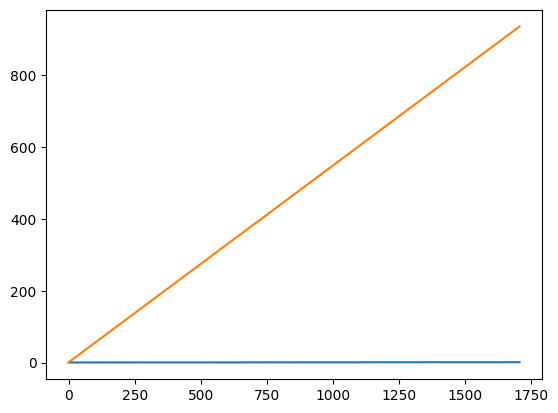

In [130]:
plt.plot(Y_test[:])
plt.plot(Y_avg[:])

In [131]:
#finding mean squared error for predicted and original values in SIMPLE MOVING AVERAGE METHOD
math.sqrt(mean_squared_error(Y_test,Y_avg))

539.9985103302996

In [132]:
#reshaping data into 3 dimesnios i.e.  (samples,timestep,1)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [133]:
#creating stacked LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))#adding 1st layer of LSTM model
model.add(LSTM(50,return_sequences=True))#adding 2nd LSTM layer
model.add(LSTM(50))#adding 3rd LSTM layer
model.add(Dense(1))#adding final output to LSTM model
model.compile(loss='mean_squared_error',optimizer='adam')

In [134]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [135]:
#training LSTM model
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
30/30 [==============================] - 12s 238ms/step - loss: 0.0025 - val_loss: 0.0727
Epoch 2/10
30/30 [==============================] - 7s 219ms/step - loss: 3.2560e-04 - val_loss: 0.0012
Epoch 3/10
30/30 [==============================] - 8s 255ms/step - loss: 1.4010e-04 - val_loss: 0.0021
Epoch 4/10
30/30 [==============================] - 7s 232ms/step - loss: 1.3327e-04 - val_loss: 0.0013
Epoch 5/10
30/30 [==============================] - 6s 202ms/step - loss: 1.2748e-04 - val_loss: 0.0013
Epoch 6/10
30/30 [==============================] - 6s 204ms/step - loss: 1.2488e-04 - val_loss: 9.1231e-04
Epoch 7/10
30/30 [==============================] - 6s 204ms/step - loss: 1.2441e-04 - val_loss: 0.0017
Epoch 8/10
30/30 [==============================] - 6s 202ms/step - loss: 1.1030e-04 - val_loss: 0.0015
Epoch 9/10
30/30 [==============================] - 6s 205ms/step - loss: 1.0123e-04 - val_loss: 0.0012
Epoch 10/10
30/30 [==============================] - 6s 212ms/s

In [136]:
#predicting values using LSTM model
Y_predicted=model.predict(X_test)
Y_predicted

54/54 [==============================] - 3s 36ms/step


array([[0.23864655],
       [0.23988011],
       [0.24111696],
       ...,
       [0.8925392 ],
       [0.8926937 ],
       [0.89186454]], dtype=float32)

In [137]:
#finding mean squared error for predicted and original values
math.sqrt(mean_squared_error(Y_test,Y_predicted))

0.03637902767706822

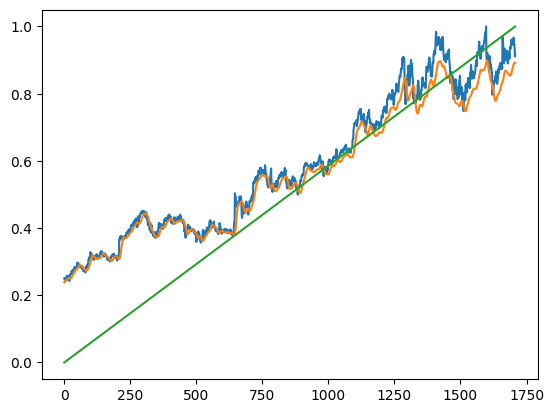

In [138]:
Y_avg=scale.fit_transform(np.array(Y_avg).reshape(-1,1))
#plotting graphs
plt.plot(Y_test)
plt.plot(Y_predicted)
plt.plot(Y_avg)